### Co-authors:   Aishwarya, Rohit , Archita

### Importing Necessary Python Libraries

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sn
import seaborn as sns

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC,SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score



In [4]:
churn_df = pd.read_csv('../data/churn_final.csv')
churn_df

,call_failure,complains,subs_len,charge_amount,seconds_of_use,freq_of_use,freq_of_sms,distinct_call_nums,tariff_plan,status,age,ageGroup,customer_value,FN,FP,Churn
0,8,0,38,0,4370,71.000000,5.000000,17.0,1,1,5,1,197.640,177.8760,69.7640,0
1,0,0,39,0,0,5.000000,7.000000,4.0,1,1,6,1,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60.000000,359.000000,24.0,1,1,2,1,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66.000000,1.000000,35.0,1,1,10,1,240.020,216.0180,74.0020,0
4,3,0,32,0,2393,58.000000,2.000000,33.0,1,1,9,1,145.805,131.2245,64.5805,0
5,11,0,38,1,3775,82.000000,32.000000,0.0,1,1,15,1,282.280,254.0520,78.2280,0
6,4,0,38,0,2360,39.000000,285.000000,18.0,1,1,1,1,1235.960,1112.3640,173.5960,0
7,13,0,37,2,9115,121.000000,144.000000,43.0,1,1,15,1,945.440,850.8960,144.5440,0
8,7,0,38,0,13773,169.000000,73.262238,44.0,1,1,15,1,557.680,501.9120,105.7680,0
9,7,0,38,1,4515,83.000000,2.000000,25.0,1,1,11,1,191.920,172.7280,69.1920,0


<b> *The given dataset has severe class imbalance.* </b>
<b> *Let's try to visualise the data's imbalance* </b>

In [5]:

def countplot(x,df):
    """Countplot"""
    sns.set_style("dark")
    sns.set(rc={'figure.figsize':(8,8)})
    sns.countplot(x=x, data=df, palette=sns.color_palette("Paired", 7), saturation=10)
    plt.title('Count plot',fontsize = 20);
    plt.savefig('Countplot.png')
    plt.show()

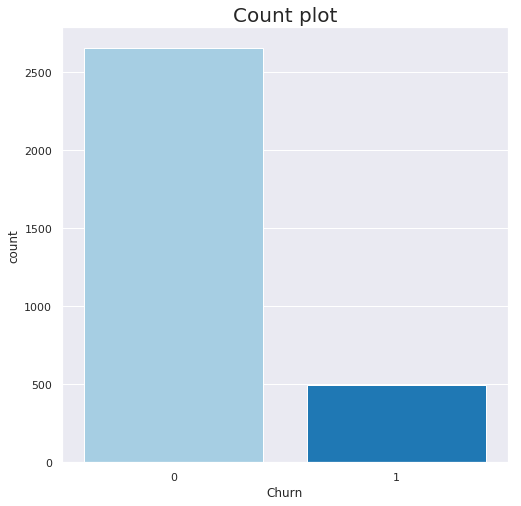

In [6]:
countplot('Churn',churn_df)

<b> *Challenge of working with imbalanced datasets:* </b>
<br>    Most machine learning techniques will ignore, and in turn have poor performance on, the minority class
<br> Biased predictions
<br> Misleading accuracy

<b> *Ways to addressing imbalanced datasets:* </b>
<br>    Oversample the minority class 

<b> Synthetic Minority Oversampling Technique </b>
<br>  It involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

<b> Balance the classes by increasing minority or decreasing majority </b>

<b> Random Under-sampling</b>
- Randomly remove majority class observations
- Helps balance the dataset
- Discarded observations could have important information
- May lead to bias

<b> Undersampling majority dataset</b>
- Randomly add more minority observations by replication
- No information loss
- Prone to overfitting due to copying same information

In [7]:
# cross-validation with 5 splits
cv = StratifiedShuffleSplit(n_splits=5, random_state = 88)
#split the data
X = churn_df.iloc[:,:15]
#store the output variable in y
y = churn_df.iloc[:,15]

In [8]:
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

### Applying SMOTE technique

In [9]:
# Applying SMOTE technique
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_smote, y_smote  = sm.fit_resample(X, y)
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_smote, y_smote, test_size=0.30, random_state=42, stratify = y_smote)

In [10]:
counter = Counter(y_smote)
print(counter)

Counter({0: 2655, 1: 2655})


Here, after applying SMOTE we treat the imbalanced data and we are able to get same number of values for both the categories i.e, churn and non-churn

In [11]:
#scale smote data
scaler = MinMaxScaler()
scaler.fit(X_smote)
X_scaled_smote = scaler.transform(X_smote)

In [12]:
# split data to X train/test and Y train/test
X_smote_train, X_smote_test, Y_smote_train, Y_smote_test = train_test_split(X_scaled_smote, y_smote, test_size=0.30, random_state=100, stratify = y_smote)

### Resampling technique - Undersampling

<b> *Under-sampling balances the dataset by reducing the size of the abundant class* </b>

In [13]:
# class count
class_count_0, class_count_1 = churn_df['Churn'].value_counts()
# divide class into two dataframes in a way, where one dataframe contains data where churn = 0 and other has data containing churn = 1)
class_0 = churn_df[churn_df['Churn'] == 0]
class_1 = churn_df[churn_df['Churn'] == 1]
# print the shape of the class
print('class 0:', class_0.shape)
print('\nclass 1:', class_1.shape)

class 0: (2655, 16)

class 1: (495, 16)


total class of 1 and 0:
 1    495
0    495
Name: Churn, dtype: int64


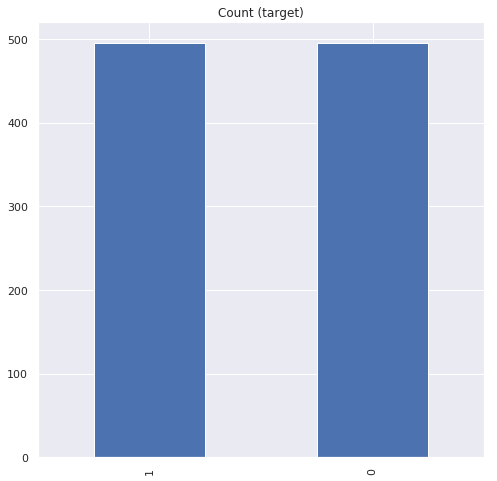

In [14]:
# Undersample the majority class, class_count_0, to the same count as class_count_1.
class_0_under = class_0.sample(class_count_1)
#Concatenating both the dataframes(One containing data where  Churn=0 and other containing data where Churn = 1) into a dataframe
test_under = pd.concat([class_0_under, class_1], axis=0)
# Print total number of samples in each class to check if data is balanced
print("total class of 1 and 0:\n",test_under['Churn'].value_counts())
# Let's visualize and check for data imbalance
test_under['Churn'].value_counts().plot(kind='bar', title='Count (target)')
plt.show()

In [15]:
#split the data
X = test_under.iloc[:,:15]
#store the output variable in y
y = test_under.iloc[:,15]
# Scaling data to 0 to 1
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
# split data to X train/test and Y train/test
X_train_undersampling, X_test_undersampling, Y_train_undersampling, Y_test_undersampling = train_test_split(X, y, test_size=0.30, random_state=100, stratify = y)

In [16]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred):
    str_out = "\n"
    str_out += ("#####  TEST SCORES  #####\n--------------------")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")

    #print AUC score
    auc = roc_auc_score(test, pred)
    str_out += ("AUC: {:.4f}\n".format(auc))
    str_out += ("\n")
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n--------------------\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n--------------------\n")

    #print classification report
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

### XGBoost model without sampling


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9513

AUC: 0.8859

CONFUSION MATRIX:
--------------------
[[782  15]
 [ 31 117]]

--------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       797
           1       0.89      0.79      0.84       148

    accuracy                           0.95       945
   macro avg       0.92      0.89      0.90       945
weighted avg       0.95      0.95      0.95       945



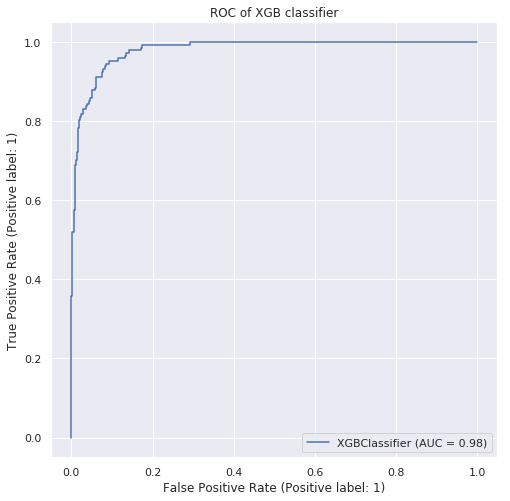


Observation: 
Built this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score


In [17]:
# Train xgbclassifier on train data
xgb = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on train data
xgb.fit(X_train, Y_train)
# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_test, predictions)
print(results)
#plot ROC curve
metrics.plot_roc_curve(xgb, X_test, Y_test)
plt.title("ROC of XGB classifier")
plt.show()
print("\n\033[1mObservation: \033[0m\nBuilt this model with imbalance data and as XGBoost can offer better performance on binary classification problems with a severe class imbalance, here we observe that the model is performing well and has good precision as well as recall score")

### XGBoost model with SMOTE 


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9711

AUC: 0.9711

CONFUSION MATRIX:
--------------------
[[769  28]
 [ 18 778]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       797
           1       0.97      0.98      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593



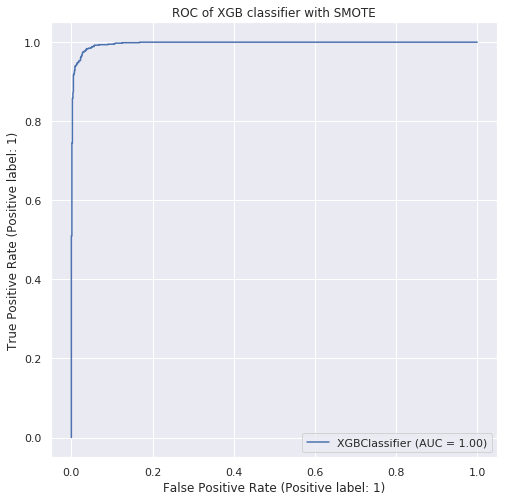


Observation: 
 Built this model with balance data(generated using SMOTE) and here we observe that the model is performing better that previous model which was built on imbalanced data even the aread under the curve has increased from 95 to 97


In [18]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions)
print(results)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.show()
print("\n\033[1mObservation: \033[0m\n Built this model with balance data(generated using SMOTE) and here we observe that the model is performing better that previous model which was built on imbalanced data even the aread under the curve has increased from 95 to 97")

### Hyperparameter tuning wrt SMOTE imputed data

<b> *Now Let's tune some of the parameters to increase the performance of our model by training it on best parameters generated by this following hyperparameter tuning process* </b>

In [19]:
n_estimators = [20,100, 500]
booster = ['gbtree','gblinear']
learning_rate = [0.1,0.20,0.01]
for i in n_estimators:
    for k in booster:
        for m in learning_rate:
            xgb = XGBClassifier(eval_metric='mlogloss',n_estimators = i,booster=k,learning_rate = m)
            # Fit xgbclassifier on train data
            xgb.fit(X_smote_train, Y_smote_train)
            # make predictions for test data
            y_pred = xgb.predict(X_smote_test)
            predictions = [round(value) for value in y_pred]
            # evaluate predictions
            accuracy = accuracy_score(Y_smote_test, predictions)
            #print("Accuracy: %.2f%%" % (accuracy * 100.0))
            if accuracy > 0.93:
                print("Best parameters: n_estimators = %d  booster = %s learning_rate = %f, accuracy = %.3f" % (i,k,m,accuracy))

Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.100000, accuracy = 0.937
Best parameters: n_estimators = 20  booster = gbtree learning_rate = 0.200000, accuracy = 0.953
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.100000, accuracy = 0.964
Best parameters: n_estimators = 100  booster = gbtree learning_rate = 0.200000, accuracy = 0.974
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.100000, accuracy = 0.969
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.200000, accuracy = 0.974
Best parameters: n_estimators = 500  booster = gbtree learning_rate = 0.010000, accuracy = 0.953


<b> *After tuning the parameters, the best accuracy that was obtained is 97.4% and the best values for the parameters are as follow:*</b>
- n_estimators : 500
- booster : gbtree
- learning_rate : 0.2


### XGBoost model with SMOTE (Using best parameters obtained during hyperparameter tuning)


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9743

AUC: 0.9743

CONFUSION MATRIX:
--------------------
[[773  24]
 [ 17 779]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       797
           1       0.97      0.98      0.97       796

    accuracy                           0.97      1593
   macro avg       0.97      0.97      0.97      1593
weighted avg       0.97      0.97      0.97      1593



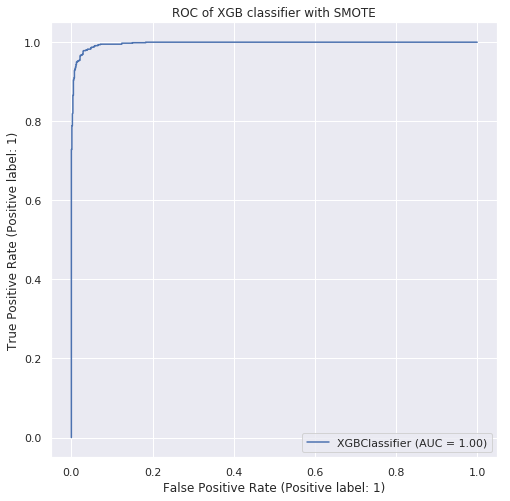


Observation1: 
So far, this one is the best XGboost model wrt balance data generated via SMOTE, here we trained the model using the best parameters obtained using the previous hyperparameter tuning method also the model's accuracy increased from 97.11 to 97.43 and even the precision and recall of the model is improved


In [20]:
# Train xgbclassifier on smote_train data
xgb_smote_clf = XGBClassifier(eval_metric='mlogloss',n_estimators = 500, booster = 'gbtree', learning_rate = 0.2)
# Fit xgbclassifier on smote_train data
xgb_smote_clf.fit(X_smote_train,Y_smote_train)
# make predictions for test data
y_pred = xgb_smote_clf.predict(X_smote_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_smote_test, predictions)
print(results)
#plot ROC curve
metrics.plot_roc_curve(xgb_smote_clf, X_smote_test, Y_smote_test)
plt.title("ROC of XGB classifier with SMOTE")
plt.show()
print("\n\033[1mObservation1: \033[0m\nSo far, this one is the best XGboost model wrt balance data generated via SMOTE, here we trained the model using the best parameters obtained using the previous hyperparameter tuning method also the model's accuracy increased from 97.11 to 97.43 and even the precision and recall of the model is improved")

### XGBoost model on undersampling imputed data


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8956

AUC: 0.8957

CONFUSION MATRIX:
--------------------
[[129  20]
 [ 11 137]]

--------------------
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       149
           1       0.87      0.93      0.90       148

    accuracy                           0.90       297
   macro avg       0.90      0.90      0.90       297
weighted avg       0.90      0.90      0.90       297



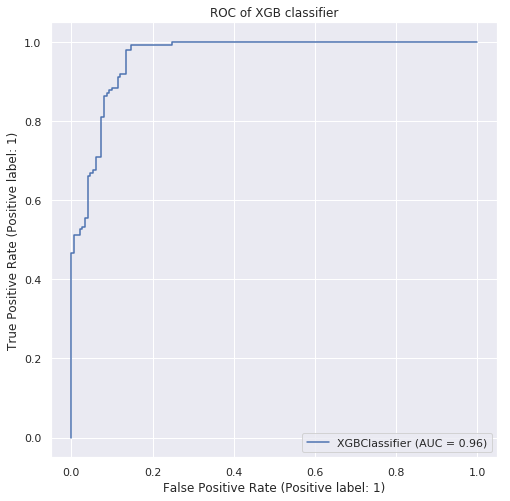


Observation1: 
We built the model using the undersampling technique of treating class imbalance and it couldnt perform better than the model built using SMOTE imputed data. We can see a drop in the accuracy(90%) this could be due to loss of information because in undersampling it balances the dataset by reducing the size of the abundant data 


In [21]:
# Train xgbclassifier on train_undersampling data
xgb = XGBClassifier(eval_metric='mlogloss')
# Fit xgbclassifier on train data
xgb.fit(X_train_undersampling, Y_train_undersampling)
# make predictions for test data
y_pred = xgb.predict(X_test_undersampling)
predictions = [round(value) for value in y_pred]
# evaluate predictions
results, false = display_test_scores(Y_test_undersampling, predictions)
print(results)
#plot ROC curve
metrics.plot_roc_curve(xgb, X_test_undersampling, Y_test_undersampling)
plt.title("ROC of XGB classifier")
plt.show()
print("\n\033[1mObservation1: \033[0m\nWe built the model using the undersampling technique of treating class imbalance and it couldnt perform better than the model built using SMOTE imputed data. We can see a drop in the accuracy(90%) this could be due to loss of information because in undersampling it balances the dataset by reducing the size of the abundant data ")

### Naive-Bayes Classifier without sampling 


*************************GaussianNB()****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.6423

AUC: 0.7577

CONFUSION MATRIX:
--------------------
[[470 327]
 [ 11 137]]

--------------------
              precision    recall  f1-score   support

           0       0.98      0.59      0.74       797
           1       0.30      0.93      0.45       148

    accuracy                           0.64       945
   macro avg       0.64      0.76      0.59       945
weighted avg       0.87      0.64      0.69       945



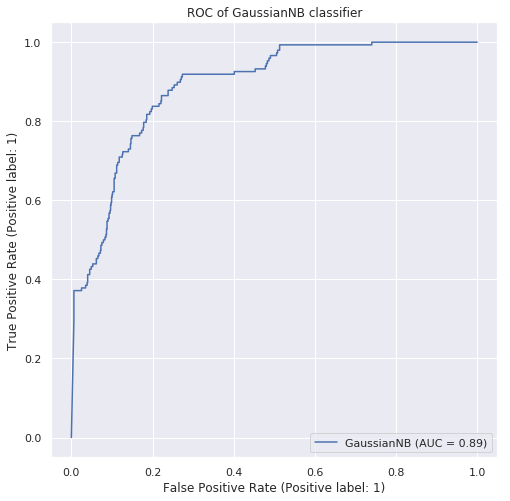


****************************MultinomialNB()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8942

AUC: 0.6759

CONFUSION MATRIX:
--------------------
[[792   5]
 [ 95  53]]

--------------------
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       797
           1       0.91      0.36      0.51       148

    accuracy                           0.89       945
   macro avg       0.90      0.68      0.73       945
weighted avg       0.90      0.89      0.87       945



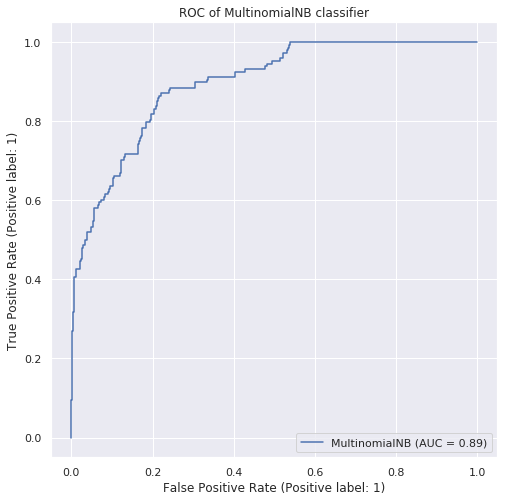


****************************ComplementNB_clf()*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8095

AUC: 0.8045

CONFUSION MATRIX:
--------------------
[[647 150]
 [ 30 118]]

--------------------
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       797
           1       0.44      0.80      0.57       148

    accuracy                           0.81       945
   macro avg       0.70      0.80      0.72       945
weighted avg       0.87      0.81      0.83       945



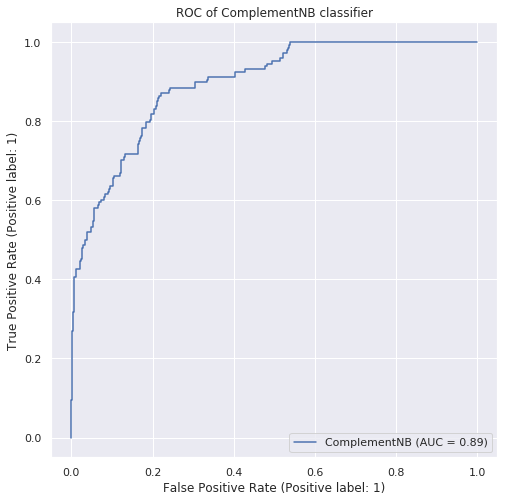

In [22]:
# Naive-Bayes with different approaches
# Naive-Bayes with different approaches

# fit GaussianNB classifier
# grid search for parameters
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, Y_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (gaussian_clf.best_params_, gaussian_clf.best_score_))

# prediction results
y_pred = gaussian_clf.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred)
print("\n*************************GaussianNB()****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_test, Y_test)
plt.title("ROC of GaussianNB classifier")
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_train, Y_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = Multinomial_clf.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred)
print("\n****************************MultinomialNB()*************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_test, Y_test)
plt.title("ROC of MultinomialNB classifier")
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_train, Y_train)


# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = ComplementNB_clf.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred)
print("\n****************************ComplementNB_clf()*************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_test, Y_test)
plt.title("ROC of ComplementNB classifier")
plt.show()


### Naive-Bayes Classifier using SMOTE sampling


*************************GaussianNB() with SMOTE sampling****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.7451

AUC: 0.7453

CONFUSION MATRIX:
--------------------
[[434 363]
 [ 43 753]]

--------------------
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       797
           1       0.67      0.95      0.79       796

    accuracy                           0.75      1593
   macro avg       0.79      0.75      0.73      1593
weighted avg       0.79      0.75      0.73      1593



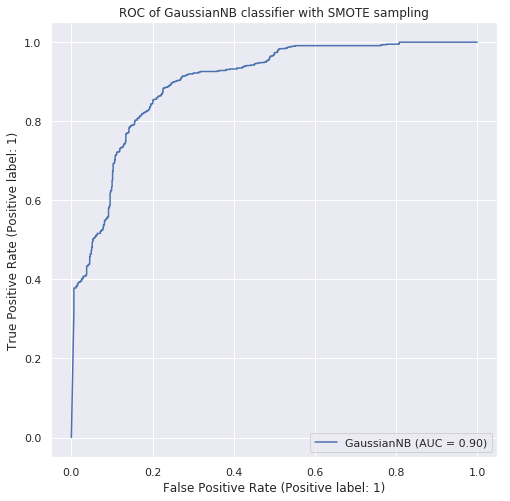


****************************MultinomialNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8286

AUC: 0.8286

CONFUSION MATRIX:
--------------------
[[640 157]
 [116 680]]

--------------------
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       797
           1       0.81      0.85      0.83       796

    accuracy                           0.83      1593
   macro avg       0.83      0.83      0.83      1593
weighted avg       0.83      0.83      0.83      1593



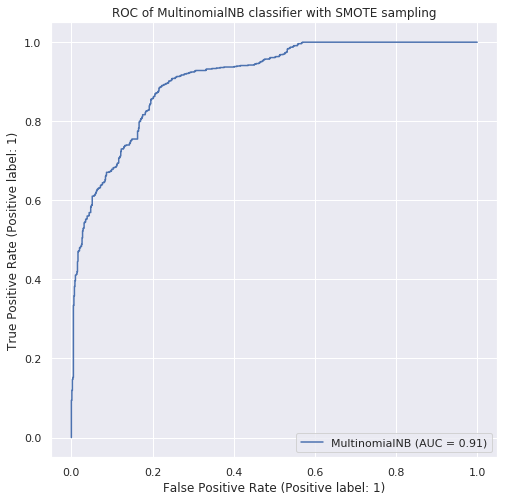


****************************ComplementNB() with SMOTE sampling*************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8293

AUC: 0.8293

CONFUSION MATRIX:
--------------------
[[641 156]
 [116 680]]

--------------------
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       797
           1       0.81      0.85      0.83       796

    accuracy                           0.83      1593
   macro avg       0.83      0.83      0.83      1593
weighted avg       0.83      0.83      0.83      1593



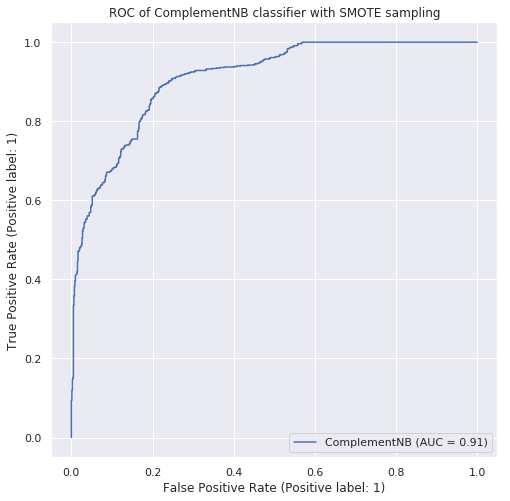

In [23]:
# Naive-Bayes with different approaches

# fit GaussianNB classifier
# grid search for parameters
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_smote_train, Y_smote_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (gaussian_clf.best_params_, gaussian_clf.best_score_))

# prediction results
y_pred = gaussian_clf.predict(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n*************************GaussianNB() with SMOTE sampling****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(gaussian_clf, X_smote_test, Y_smote_test)
plt.title("ROC of GaussianNB classifier with SMOTE sampling")
plt.show()


#====================================================================================================

# fit MultinomialNB classifier
Multinomial_clf = MultinomialNB()
Multinomial_clf.fit(X_smote_train, Y_smote_train)



# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = Multinomial_clf.predict(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n****************************MultinomialNB() with SMOTE sampling*************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(Multinomial_clf, X_smote_test, Y_smote_test)
plt.title("ROC of MultinomialNB classifier with SMOTE sampling")
plt.show()



#====================================================================================================

ComplementNB_clf = ComplementNB()
ComplementNB_clf.fit(X_smote_train, Y_smote_train)


# print best scores
# print("The best parameters are %s with a score of %0.4f\n"
#       % (Multinomial_clf.best_params_, Multinomial_clf.best_score_))

# prediction results
y_pred = ComplementNB_clf.predict(X_smote_test)

# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n****************************ComplementNB() with SMOTE sampling*************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(ComplementNB_clf, X_smote_test, Y_smote_test)
plt.title("ROC of ComplementNB classifier with SMOTE sampling")
plt.show()


### SVM Classifier without sampling 

The best parameters are {'C': 100, 'class_weight': None, 'kernel': 'rbf'} with a score of 0.9152


Run time for train&test cv SVM :  8.07702922821045

*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9111

AUC: 0.7630

CONFUSION MATRIX:
--------------------
[[780  17]
 [ 67  81]]

--------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       797
           1       0.83      0.55      0.66       148

    accuracy                           0.91       945
   macro avg       0.87      0.76      0.80       945
weighted avg       0.91      0.91      0.90       945



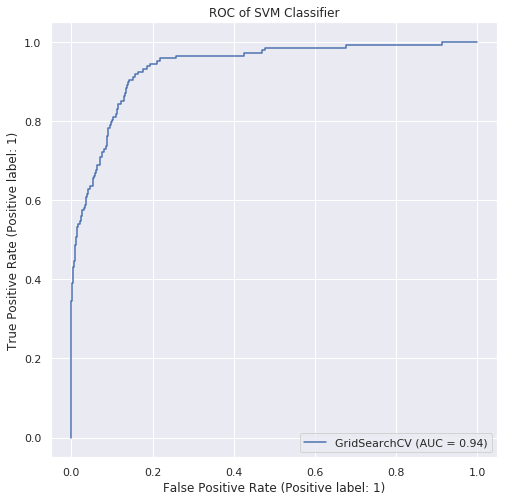

In [24]:

# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000, tol=1e-5), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_train, Y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_test)

end_time=time.time()

print("\nRun time for train&test cv SVM : ", end_time-start_time)




# print accuracy metrics
results, false = display_test_scores(Y_test, y_pred)
print("\n*************************SVM Classifier****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_test, Y_test)
plt.title("ROC of SVM Classifier")
plt.show()




### SVM Classifier with SMOTE

The best parameters are {'C': 100, 'class_weight': None, 'kernel': 'rbf'} with a score of 0.8889


Run time for train&test cv SVM :  26.555021286010742

*************************SVM Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8669

AUC: 0.8669

CONFUSION MATRIX:
--------------------
[[681 116]
 [ 96 700]]

--------------------
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       797
           1       0.86      0.88      0.87       796

    accuracy                           0.87      1593
   macro avg       0.87      0.87      0.87      1593
weighted avg       0.87      0.87      0.87      1593



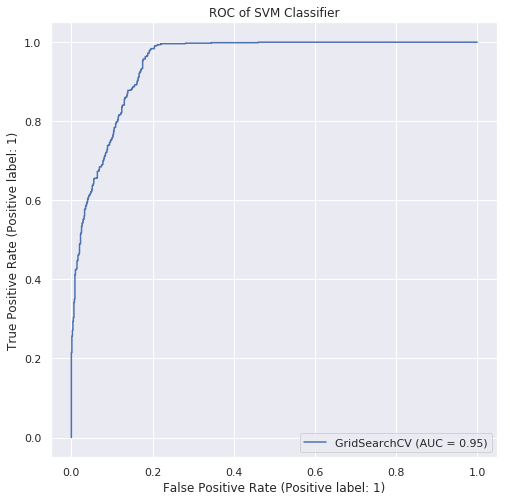

In [25]:

# SVM Classifier with different approaches

# parameters 
parameters = {
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            }

start_time=time.time()

# grid search for parameters
#tol is the tolerance for stopping criteria
SVM_grid_clf = GridSearchCV(SVC(degree=5, max_iter=1000), cv = 5, param_grid=parameters, n_jobs=-1, refit=True )
SVM_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f\n"
      % (SVM_grid_clf.best_params_, SVM_grid_clf.best_score_))

# prediction results
y_pred = SVM_grid_clf.predict(X_smote_test)

end_time=time.time()

print("\nRun time for train&test cv SVM : ", end_time-start_time)


# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n*************************SVM Classifier****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(SVM_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of SVM Classifier")
plt.show()


### Decision Tree Classifier without sampling 

The best parameters are {'class_weight': 'balanced', 'max_depth': 17, 'splitter': 'best'} with a score of 0.8963

Run time for train&test cv (DT-gini):  0.3827016353607178

*************************Decision Tree Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.8588

AUC: 0.8587

CONFUSION MATRIX:
--------------------
[[778  19]
 [206 590]]

--------------------
              precision    recall  f1-score   support

           0       0.79      0.98      0.87       797
           1       0.97      0.74      0.84       796

    accuracy                           0.86      1593
   macro avg       0.88      0.86      0.86      1593
weighted avg       0.88      0.86      0.86      1593



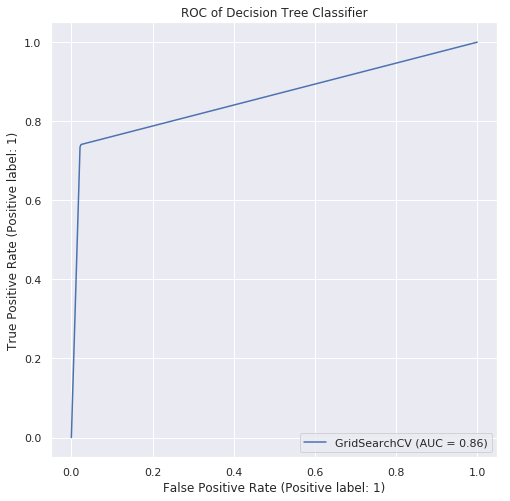

In [26]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_test, Y_test)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_smote_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of Decision Tree Classifier")
plt.show()





### Decision Tree Classifier with SMOTE

The best parameters are {'class_weight': None, 'max_depth': None, 'splitter': 'best'} with a score of 0.9354

Run time for train&test cv (DT-gini):  0.8234312534332275

*************************Decision Tree Classifier****************************************


#####  TEST SCORES  #####
--------------------
ACCURACY: 0.9353

AUC: 0.9353

CONFUSION MATRIX:
--------------------
[[746  51]
 [ 52 744]]

--------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       797
           1       0.94      0.93      0.94       796

    accuracy                           0.94      1593
   macro avg       0.94      0.94      0.94      1593
weighted avg       0.94      0.94      0.94      1593



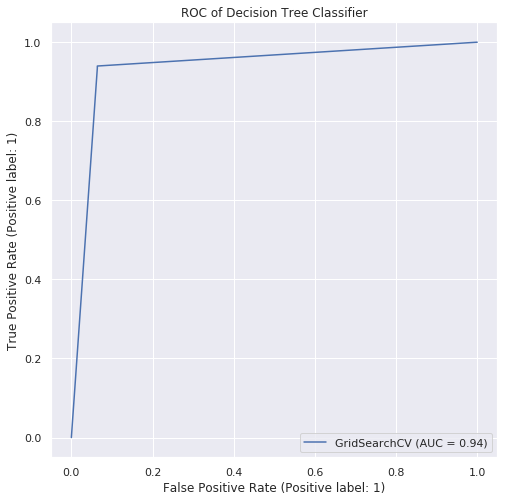

In [27]:
# decision tree with "gini"
dt = DecisionTreeClassifier(random_state = 0, criterion="gini")

# parameters 
parameters = {
                "splitter": ["best","random"],
                "class_weight": [None, "balanced"],
                "max_depth": [9, 11, 13, 15, 17,None]
                }

start_time=time.time()

# grid search for parameters
dt_grid_clf = GridSearchCV(estimator=dt, param_grid=parameters, cv=5,n_jobs=-1)
dt_grid_clf.fit(X_smote_train, Y_smote_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (dt_grid_clf.best_params_, dt_grid_clf.best_score_))


# prediction results
y_pred = dt_grid_clf.predict(X_smote_test)

end_time=time.time()##
print("\nRun time for train&test cv (DT-gini): ",end_time-start_time)



# print accuracy metrics
results, false = display_test_scores(Y_smote_test, y_pred)
print("\n*************************Decision Tree Classifier****************************************\n")
print(results)

#plot ROC curve
metrics.plot_roc_curve(dt_grid_clf, X_smote_test, Y_smote_test)
plt.title("ROC of Decision Tree Classifier")
plt.show()





#### TODO: Interactive ROC curve

In [28]:
# def plot_interactive_roc_curve(df, fpr, tpr, thresholds):
#     fig = px.area(
#         data_frame=df, 
#         x=fpr, 
#         y=tpr,
#         hover_data=thresholds, 
#         title='ROC Curve'
#     )
#     fig.update_layout(
#         autosize=False,
#         width=500,
#         height=500,
#         margin=dict(l=30, r=30, b=30, t=30, pad=4),
#         title_x=.5, # Centre title
#         hovermode = 'closest',
#         xaxis=dict(hoverformat='.4f'),
#         yaxis=dict(hoverformat='.4f')
#     )
#     hovertemplate = 'False Positive Rate=%{x}<br>True Positive Rate=%{y}<br>Threshold=%{customdata[0]:.4f}<extra></extra>'
#     fig.update_traces(hovertemplate=hovertemplate)
    
#     # Add dashed line with a slope of 1
#     fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
#     fig.show()
    
# plot_interactive_roc_curve(df=churn_df, 
#                            fpr='false_positive_rate', 
#                            tpr='true_positive_rate', 
#                            thresholds=['threshold'])

### TODO : Final ROC for multiple classifiers